# PROJECT LUNG DISEASES

## REQUIREMENT

In [1]:
import os
import random
import shutil
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import tensorflow as tf
from tensorflow.keras.layers import TimeDistributed, Bidirectional, LSTM
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50, VGG19, InceptionV3
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import precision_score, recall_score, f1_score

## DATA PREP

In [2]:
! pip install -q kaggle
from google.colab import files
#upload kaggle.json API akun pribadi
files.upload()
# make directory for save the dataset
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
# Import dataset from kaggle to colab
! kaggle datasets download -d anjay007/penyakit-paru-paru-5-kelas

Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/anjay007/penyakit-paru-paru-5-kelas
License(s): CC0-1.0
 97% 271M/280M [00:03<00:00, 140MB/s]
100% 280M/280M [00:03<00:00, 96.8MB/s]


In [3]:
! unzip  /content/penyakit-paru-paru-5-kelas.zip -d lung_disease/
#menghapus zip file dataset
!rm -r /content/penyakit-paru-paru-5-kelas.zip
#menghapus zip file dataset
!rm -r /content/kaggle.json

Output streaming akan dipotong hingga 5000 baris terakhir.
  inflating: lung_disease/train_dir/bacterial_pneumonia/person26_bacteria_132.jpeg  
  inflating: lung_disease/train_dir/bacterial_pneumonia/person26_bacteria_133.jpeg  
  inflating: lung_disease/train_dir/bacterial_pneumonia/person27_bacteria_135.jpeg  
  inflating: lung_disease/train_dir/bacterial_pneumonia/person27_bacteria_136.jpeg  
  inflating: lung_disease/train_dir/bacterial_pneumonia/person27_bacteria_137.jpeg  
  inflating: lung_disease/train_dir/bacterial_pneumonia/person29_bacteria_144.jpeg  
  inflating: lung_disease/train_dir/bacterial_pneumonia/person2_bacteria_3.jpeg  
  inflating: lung_disease/train_dir/bacterial_pneumonia/person30_bacteria_147.jpeg  
  inflating: lung_disease/train_dir/bacterial_pneumonia/person30_bacteria_148.jpeg  
  inflating: lung_disease/train_dir/bacterial_pneumonia/person30_bacteria_149.jpeg  
  inflating: lung_disease/train_dir/bacterial_pneumonia/person30_bacteria_150.jpeg  
  inflati

In [4]:

BASE_DIR = '/content/lung_disease/Lung Disease Dataset'

#Path train, test, dan validation
train = '/content/lung_disease/train_dir'
val = '/content/lung_disease/test_dir'

### Datagenerator

In [5]:
# Membuat objek ImageDataGenerator untuk augmentasi data pada set pelatihan
train_datagen = ImageDataGenerator(
    rescale=1./255,
    zoom_range=0.05,
    rotation_range=180,
    width_shift_range=0.1,
    height_shift_range=0.1
)

# Membuat objek ImageDataGenerator untuk preprocessing pada set pengujian dan validasi
test_val_datagen = ImageDataGenerator(rescale=1./255)

# Menggunakan objek ImageDataGenerator untuk memuat data gambar dari direktori dan melakukan augmentasi
train_generator = train_datagen.flow_from_directory(
    train,
    target_size=(224, 224),
    class_mode='categorical',  # Mode kelas untuk klasifikasi banyak kelas
    batch_size = 16
)

val_generator = test_val_datagen.flow_from_directory(
    val,
    target_size=(224, 224),
    class_mode='categorical',
    batch_size = 8
)


Found 6080 images belonging to 5 classes.
Found 982 images belonging to 5 classes.


## TRAINNING W RESNET50

### Load pretrined CNN

In [ ]:
# Memuat model ResNet50 tanpa layer teratas (top layer)
resnet_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the convolutional layers
for layer in resnet_model.layers:
    layer.trainable = False

94765736/94765736 [==============================] - 0s 0us/step


### Project Model

In [ ]:
#Membuat model
model_resnet = Sequential()
model_resnet.add(resnet_model)
model_resnet.add(TimeDistributed(Flatten()))
model_resnet.add(Bidirectional(LSTM(128, return_sequences=True)))
model_resnet.add(Bidirectional(LSTM(32, return_sequences=True)))
model_resnet.add(Dropout(0.2))
model_resnet.add(Dense(256, activation='relu'))
model_resnet.add(Dense(64, activation='relu'))
model_resnet.add(Dropout(0.2))
model_resnet.add(Flatten())
model_resnet.add(Dense(train_generator.num_classes, activation='softmax'))

print(model_resnet.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 time_distributed (TimeDist  (None, 7, 14336)          0         
 ributed)                                                        
                                                                 
 bidirectional (Bidirection  (None, 7, 256)            14812160  
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 7, 64)             73984     
 onal)                                                           
                                                                 
 dropout (Dropout)           (None, 7, 64)             0         
                                                        

In [ ]:
# Compile model
model_resnet.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['acc'])
class CustomCallback(tf.keras.callbacks.Callback):
    total_above_target = 0
    def on_epoch_end(self, epoch, logs=None):
        if logs["val_acc"] > 0.90 and logs["acc"] > 0.88:
            self.total_above_target += 1
            if self.total_above_target > 3:
                self.model.stop_training = True

callback = CustomCallback()
# Train model
history = model_resnet.fit(
    train_generator,
    epochs=30,
    validation_data=val_generator,
    callbacks=callback
)

Epoch 1/30
380/380 [==============================] - 127s 294ms/step - loss: 1.6131 - acc: 0.2086 - val_loss: 1.6084 - val_acc: 0.2128
Epoch 2/30
380/380 [==============================] - 99s 261ms/step - loss: 1.6103 - acc: 0.2041 - val_loss: 1.6030 - val_acc: 0.2128
Epoch 3/30
380/380 [==============================] - 107s 282ms/step - loss: 1.6094 - acc: 0.2061 - val_loss: 1.6059 - val_acc: 0.2189
Epoch 4/30
380/380 [==============================] - 105s 276ms/step - loss: 1.6037 - acc: 0.2276 - val_loss: 1.5937 - val_acc: 0.2271
Epoch 5/30
380/380 [==============================] - 100s 262ms/step - loss: 1.5654 - acc: 0.2829 - val_loss: 1.5417 - val_acc: 0.2322
Epoch 6/30
380/380 [==============================] - 99s 261ms/step - loss: 1.4831 - acc: 0.3484 - val_loss: 1.4063 - val_acc: 0.3890
Epoch 7/30
380/380 [==============================] - 98s 257ms/step - loss: 1.3416 - acc: 0.4087 - val_loss: 1.7995 - val_acc: 0.2800
Epoch 8/30
380/380 [==============================]

model_resnet.save("resnet_model.h5")
with open('history_resnet.txt', mode='w') as file:
    file.write(str(history.history['acc'])+'/n'+str(history.history['loss']))
    file.close()

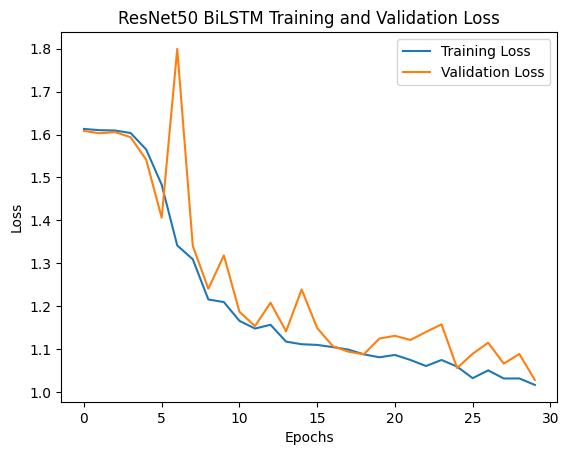

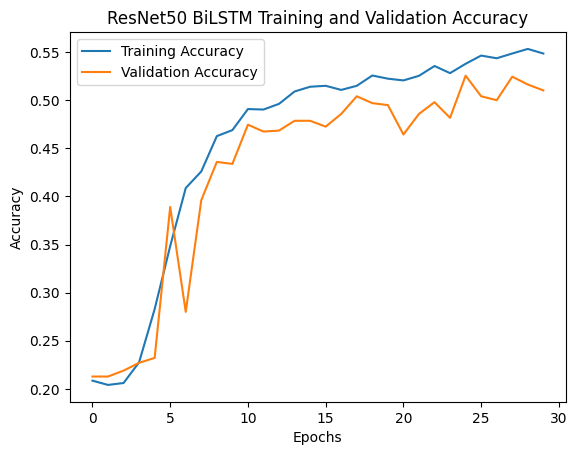

In [ ]:
# Plot loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('ResNet50 BiLSTM Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot accuracy
plt.plot(history.history['acc'], label='Training Accuracy')
plt.plot(history.history['val_acc'], label='Validation Accuracy')
plt.title('ResNet50 BiLSTM Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
results = model_resnet.evaluate(val_generator)

print("Loss:", results[0])
print("Accuracy:", results[1])

123/123 [==============================] - 6s 46ms/step - loss: 1.0283 - acc: 0.5102
Loss: 1.0283061265945435
Accuracy: 0.5101832747459412


In [ ]:
train_predictions = model_resnet.predict(train_generator, verbose=1)
train_predicted_labels = np.argmax(train_predictions, axis=1)
train_true_labels = train_generator.classes

train_class_report = classification_report(train_true_labels,
                                          train_predicted_labels, target_names=train_generator.class_indices,
                                          digits=5)
print("\nResNet50 BiLSTM Training classification report:\n", train_class_report)



380/380 [==============================] - 93s 239ms/step

ResNet50 BiLSTM Training classification report:
                      precision    recall  f1-score   support

bacterial_pneumonia    0.19541   0.18852   0.19191      1220
            covid19    0.19884   0.22124   0.20944      1243
             normal    0.17867   0.15870   0.16810      1235
       tuberculosis    0.18151   0.18462   0.18305      1170
    viral_pneumonia    0.19951   0.20297   0.20123      1212

           accuracy                        0.19128      6080
          macro avg    0.19079   0.19121   0.19074      6080
       weighted avg    0.19086   0.19128   0.19081      6080



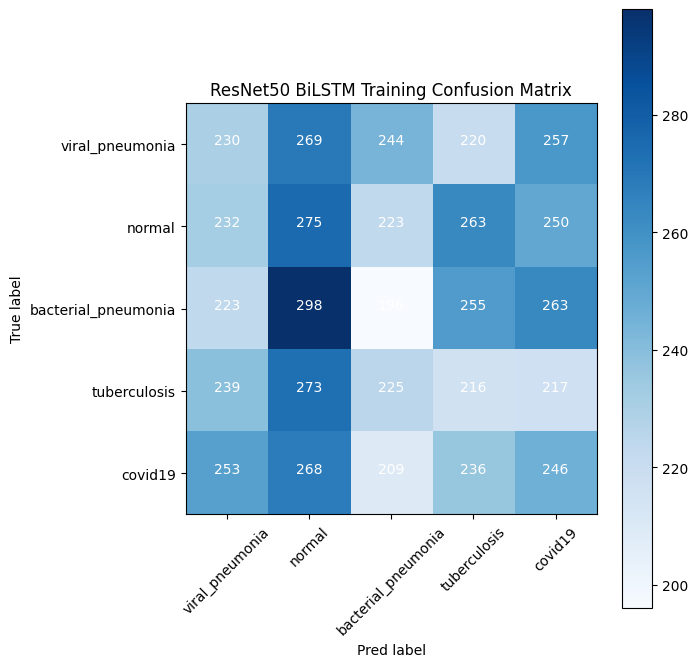

In [ ]:
inp = '/content/lung_disease'
classes = []
filename = inp
for sub_folder in os.listdir(os.path.join(filename, 'train_dir')):
    classes.append(sub_folder)
# print(classes)
classname_label = classes
train_conf_matrix = confusion_matrix(train_true_labels, train_predicted_labels)

# Plot
plt.figure(figsize=(7, 7))
plt.imshow(train_conf_matrix, interpolation="nearest", cmap=plt.cm.Blues)
plt.title("ResNet50 BiLSTM Training Confusion Matrix")
plt.colorbar()

tick_marks = np.arange(len(classname_label))
plt.xticks(tick_marks, classname_label, rotation=45)
plt.yticks(tick_marks, classname_label)

thresh = train_conf_matrix.max() / 2.0
for i, j in itertools.product(
    range(train_conf_matrix.shape[0]), range(train_conf_matrix.shape[1])
):
    plt.text(
        j,
        i,
        train_conf_matrix[i, j],
        horizontalalignment="center",
        color="white" if train_conf_matrix[i, j] > thresh else "black",
    )

plt.tight_layout()
plt.ylabel("True label")
plt.xlabel("Pred label")
plt.show()

## TRAINNING W VGG19


### Load Pretrained CNN

In [6]:
VGG19_model =VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the convolutional layers
for layer in VGG19_model.layers:
    layer.trainable = False

80134624/80134624 [==============================] - 1s 0us/step


### Our Model

In [7]:
#Membuat model
model_VGG19 = Sequential()
model_VGG19.add(VGG19_model)
model_VGG19.add(TimeDistributed(Flatten()))
model_VGG19.add(Bidirectional(LSTM(128, return_sequences=True)))
model_VGG19.add(Bidirectional(LSTM(32, return_sequences=True)))
model_VGG19.add(Dropout(0.2))
model_VGG19.add(Dense(256, activation='relu'))
model_VGG19.add(Dense(64, activation='relu'))
model_VGG19.add(Dropout(0.2))
model_VGG19.add(Flatten())
model_VGG19.add(Dense(train_generator.num_classes, activation='softmax'))

print(model_VGG19.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 time_distributed (TimeDist  (None, 7, 3584)           0         
 ributed)                                                        
                                                                 
 bidirectional (Bidirection  (None, 7, 256)            3802112   
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 7, 64)             73984     
 onal)                                                           
                                                                 
 dropout (Dropout)           (None, 7, 64)             0         
                                                        

In [8]:
# Compile model
model_VGG19.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['acc'])
class CustomCallback(tf.keras.callbacks.Callback):
    total_above_target = 0
    def on_epoch_end(self, epoch, logs=None):
        if logs["val_acc"] > 0.90 and logs["acc"] > 0.88:
            self.total_above_target += 1
            if self.total_above_target > 3:
                self.model.stop_training = True
callback = CustomCallback()
# Train model
history_VGG19 = model_VGG19.fit(
    train_generator,
    epochs=30,
    validation_data=val_generator,
    callbacks=callback
)

Epoch 1/30
380/380 [==============================] - 120s 278ms/step - loss: 1.1686 - acc: 0.5003 - val_loss: 0.8461 - val_acc: 0.6650
Epoch 2/30
380/380 [==============================] - 102s 268ms/step - loss: 0.8416 - acc: 0.6304 - val_loss: 0.7403 - val_acc: 0.6660
Epoch 3/30
380/380 [==============================] - 105s 277ms/step - loss: 0.7593 - acc: 0.6771 - val_loss: 0.7038 - val_acc: 0.7098
Epoch 4/30
380/380 [==============================] - 99s 261ms/step - loss: 0.6995 - acc: 0.7049 - val_loss: 0.6189 - val_acc: 0.7393
Epoch 5/30
380/380 [==============================] - 98s 257ms/step - loss: 0.6635 - acc: 0.7263 - val_loss: 0.5904 - val_acc: 0.7780
Epoch 6/30
380/380 [==============================] - 98s 259ms/step - loss: 0.6027 - acc: 0.7441 - val_loss: 0.6329 - val_acc: 0.7301
Epoch 7/30
380/380 [==============================] - 97s 257ms/step - loss: 0.6115 - acc: 0.7515 - val_loss: 0.6193 - val_acc: 0.7413
Epoch 8/30
380/380 [==============================] 

In [ ]:
model_VGG19.save("VGG19_model_skenario1.h5")
with open('history_VGG19.txt', mode='w') as file:
    file.write(str(history_VGG19.history['acc'])+'/n'+str(history_VGG19.history['loss']))
    file.close()

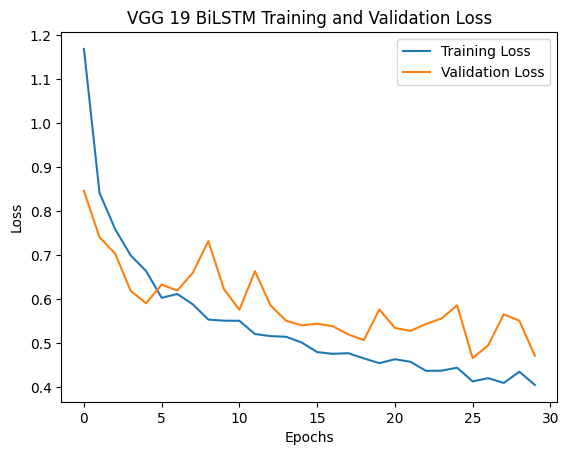

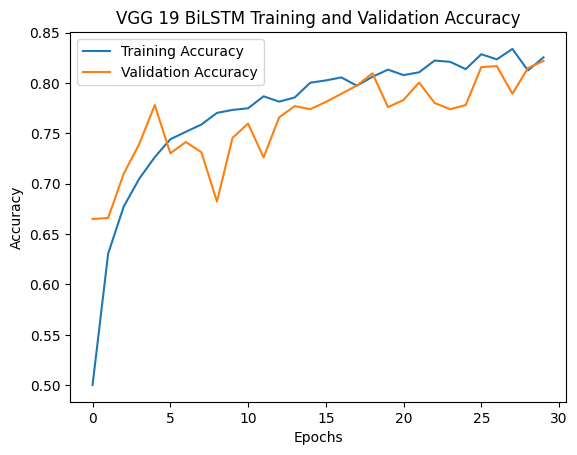

In [9]:
# Plot loss
plt.plot(history_VGG19.history['loss'], label='Training Loss')
plt.plot(history_VGG19.history['val_loss'], label='Validation Loss')
plt.title('VGG 19 BiLSTM Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot accuracy
plt.plot(history_VGG19.history['acc'], label='Training Accuracy')
plt.plot(history_VGG19.history['val_acc'], label='Validation Accuracy')
plt.title('VGG 19 BiLSTM Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [10]:
results = model_VGG19.evaluate(val_generator)

print("Loss:", results[0])
print("Accuracy:", results[1])

123/123 [==============================] - 8s 64ms/step - loss: 0.4712 - acc: 0.8218
Loss: 0.47124722599983215
Accuracy: 0.8217922449111938


In [11]:
train_predictions = model_VGG19.predict(train_generator, verbose=1)
train_predicted_labels = np.argmax(train_predictions, axis=1)
train_true_labels = train_generator.classes

train_class_report = classification_report(train_true_labels,
                                          train_predicted_labels, target_names=train_generator.class_indices,
                                          digits=5)
print("\nVGG 19 BiLSTM Training classification report:\n", train_class_report)



380/380 [==============================] - 93s 241ms/step

VGG 19 BiLSTM Training classification report:
                      precision    recall  f1-score   support

bacterial_pneumonia    0.22233   0.19426   0.20735      1220
            covid19    0.20089   0.21802   0.20910      1243
             normal    0.20223   0.17652   0.18850      1235
       tuberculosis    0.18073   0.18120   0.18096      1170
    viral_pneumonia    0.19448   0.22690   0.20944      1212

           accuracy                        0.19951      6080
          macro avg    0.20013   0.19938   0.19907      6080
       weighted avg    0.20031   0.19951   0.19922      6080



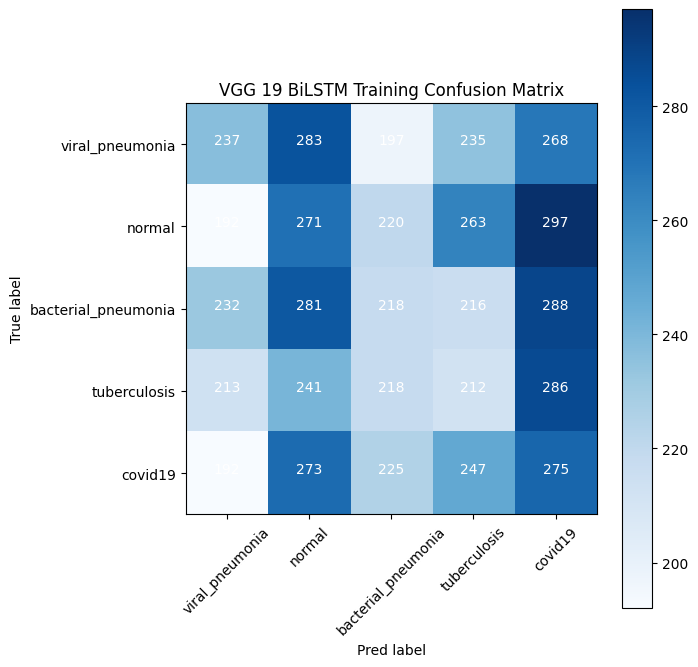

In [12]:
inp = '/content/lung_disease'
classes = []
filename = inp
for sub_folder in os.listdir(os.path.join(filename, 'train_dir')):
    classes.append(sub_folder)
# print(classes)
classname_label = classes
train_conf_matrix = confusion_matrix(train_true_labels, train_predicted_labels)

# Plot
plt.figure(figsize=(7, 7))
plt.imshow(train_conf_matrix, interpolation="nearest", cmap=plt.cm.Blues)
plt.title("VGG 19 BiLSTM Training Confusion Matrix")
plt.colorbar()

tick_marks = np.arange(len(classname_label))
plt.xticks(tick_marks, classname_label, rotation=45)
plt.yticks(tick_marks, classname_label)

thresh = train_conf_matrix.max() / 2.0
for i, j in itertools.product(
    range(train_conf_matrix.shape[0]), range(train_conf_matrix.shape[1])
):
    plt.text(
        j,
        i,
        train_conf_matrix[i, j],
        horizontalalignment="center",
        color="white" if train_conf_matrix[i, j] > thresh else "black",
    )

plt.tight_layout()
plt.ylabel("True label")
plt.xlabel("Pred label")
plt.show()

## TRAINNING W InceptionV3


### Load Pretrained CNN

In [13]:
InceptionV3_model = InceptionV3(weights='imagenet',
                                include_top=False, input_shape=(224, 224, 3))
# Freeze the convolutional layers
for layer in InceptionV3_model.layers:
    layer.trainable = False

87910968/87910968 [==============================] - 1s 0us/step


In [14]:
#Membuat model
model_InceptionV3 = Sequential()
model_InceptionV3.add(InceptionV3_model)
model_InceptionV3.add(TimeDistributed(Flatten()))
model_InceptionV3.add(Bidirectional(LSTM(128, return_sequences=True)))
model_InceptionV3.add(Bidirectional(LSTM(32, return_sequences=True)))
model_InceptionV3.add(Dropout(0.2))
model_InceptionV3.add(Dense(256, activation='relu'))
model_InceptionV3.add(Dense(64, activation='relu'))
model_InceptionV3.add(Dropout(0.2))
model_InceptionV3.add(Flatten())
model_InceptionV3.add(Dense(train_generator.num_classes, activation='softmax'))
print(model_InceptionV3.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 time_distributed_1 (TimeDi  (None, 5, 10240)          0         
 stributed)                                                      
                                                                 
 bidirectional_2 (Bidirecti  (None, 5, 256)            10617856  
 onal)                                                           
                                                                 
 bidirectional_3 (Bidirecti  (None, 5, 64)             73984     
 onal)                                                           
                                                                 
 dropout_2 (Dropout)         (None, 5, 64)             0         
                                                      

In [15]:
# Compile model
model_InceptionV3.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['acc'])
class CustomCallback(tf.keras.callbacks.Callback):
    total_above_target = 0
    def on_epoch_end(self, epoch, logs=None):
        if logs["val_acc"] > 0.90 and logs["acc"] > 0.88:
            self.total_above_target += 1
            if self.total_above_target > 3:
                self.model.stop_training = True
callback = CustomCallback()
# Train model
history_InceptionV3 = model_InceptionV3.fit(
    train_generator,
    epochs=30,
    validation_data=val_generator,
    callbacks=callback
)

Epoch 1/30
380/380 [==============================] - 117s 273ms/step - loss: 0.9931 - acc: 0.5625 - val_loss: 0.8018 - val_acc: 0.6497
Epoch 2/30
380/380 [==============================] - 96s 254ms/step - loss: 0.6797 - acc: 0.7026 - val_loss: 0.7727 - val_acc: 0.6619
Epoch 3/30
380/380 [==============================] - 94s 247ms/step - loss: 0.6068 - acc: 0.7474 - val_loss: 0.6834 - val_acc: 0.7016
Epoch 4/30
380/380 [==============================] - 95s 251ms/step - loss: 0.5747 - acc: 0.7612 - val_loss: 0.6438 - val_acc: 0.7159
Epoch 5/30
380/380 [==============================] - 94s 248ms/step - loss: 0.5391 - acc: 0.7776 - val_loss: 0.8559 - val_acc: 0.6517
Epoch 6/30
380/380 [==============================] - 94s 248ms/step - loss: 0.5134 - acc: 0.7910 - val_loss: 0.6453 - val_acc: 0.7169
Epoch 7/30
380/380 [==============================] - 93s 245ms/step - loss: 0.4978 - acc: 0.7918 - val_loss: 0.7320 - val_acc: 0.6711
Epoch 8/30
380/380 [==============================] - 

In [ ]:
model_InceptionV3.save("InceptionV3_model.h5")
with open('history_InceptionV3.txt', mode='w') as file:
    file.write(str(history_InceptionV3.history['acc'])+'/n'+str(history_InceptionV3.history['loss']))
    file.close()

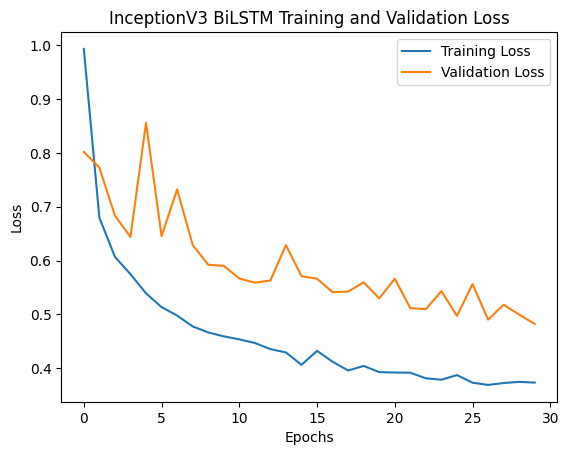

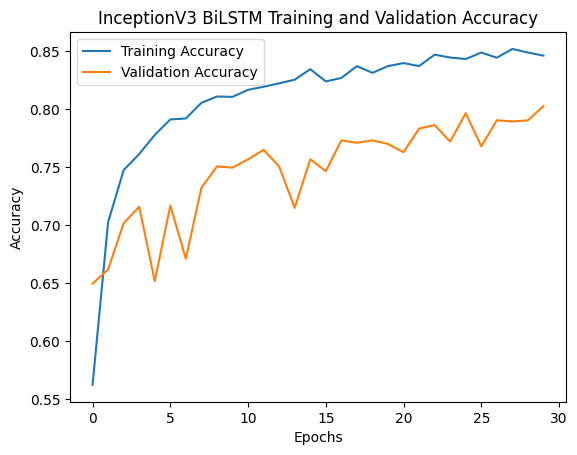

In [16]:
# Plot loss
plt.plot(history_InceptionV3.history['loss'], label='Training Loss')
plt.plot(history_InceptionV3.history['val_loss'], label='Validation Loss')
plt.title('InceptionV3 BiLSTM Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot accuracy
plt.plot(history_InceptionV3.history['acc'], label='Training Accuracy')
plt.plot(history_InceptionV3.history['val_acc'], label='Validation Accuracy')
plt.title('InceptionV3 BiLSTM Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [17]:
results = model_InceptionV3.evaluate(val_generator)

print("Loss:", results[0])
print("Accuracy:", results[1])

123/123 [==============================] - 6s 44ms/step - loss: 0.4823 - acc: 0.8024
Loss: 0.48225152492523193
Accuracy: 0.8024439811706543


In [18]:
train_predictions = model_InceptionV3.predict(train_generator, verbose=1)
train_predicted_labels = np.argmax(train_predictions, axis=1)
train_true_labels = train_generator.classes

train_class_report = classification_report(train_true_labels,
                                          train_predicted_labels, target_names=train_generator.class_indices,
                                          digits=5)
print("\nInceptionV3 BiLSTM Training classification report:\n", train_class_report)



380/380 [==============================] - 90s 230ms/step

InceptionV3 BiLSTM Training classification report:
                      precision    recall  f1-score   support

bacterial_pneumonia    0.21348   0.21803   0.21573      1220
            covid19    0.19909   0.17619   0.18694      1243
             normal    0.21810   0.23806   0.22764      1235
       tuberculosis    0.19442   0.20256   0.19841      1170
    viral_pneumonia    0.19966   0.19224   0.19588      1212

           accuracy                        0.20543      6080
          macro avg    0.20495   0.20542   0.20492      6080
       weighted avg    0.20505   0.20543   0.20497      6080



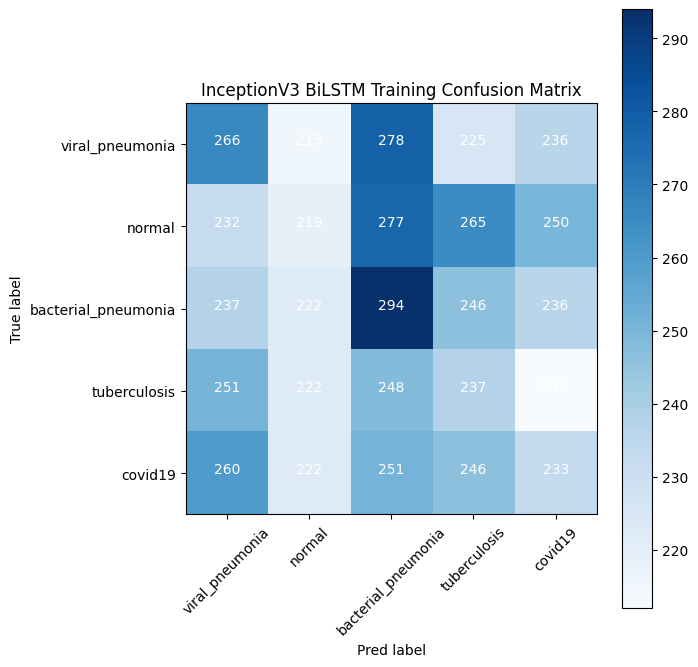

In [19]:
inp = '/content/lung_disease'
classes = []
filename = inp
for sub_folder in os.listdir(os.path.join(filename, 'train_dir')):
    classes.append(sub_folder)
# print(classes)
classname_label = classes
train_conf_matrix = confusion_matrix(train_true_labels, train_predicted_labels)

# Plot
plt.figure(figsize=(7, 7))
plt.imshow(train_conf_matrix, interpolation="nearest", cmap=plt.cm.Blues)
plt.title("InceptionV3 BiLSTM Training Confusion Matrix")
plt.colorbar()

tick_marks = np.arange(len(classname_label))
plt.xticks(tick_marks, classname_label, rotation=45)
plt.yticks(tick_marks, classname_label)

thresh = train_conf_matrix.max() / 2.0
for i, j in itertools.product(
    range(train_conf_matrix.shape[0]), range(train_conf_matrix.shape[1])
):
    plt.text(
        j,
        i,
        train_conf_matrix[i, j],
        horizontalalignment="center",
        color="white" if train_conf_matrix[i, j] > thresh else "black",
    )

plt.tight_layout()
plt.ylabel("True label")
plt.xlabel("Pred label")
plt.show()